# Simulating Contact Tracing in Pandemic
#### **Non-Gaussian Process Based Experimentations**

This notebook contains sensitivity analysis experiments using non-Gaussian-process based approaches for understanding the effect of variables to COVID-19 spread rate in the UK.

In [9]:
# If need to install packages
# !git clone https://github.com/rs-delve/tti-explorer.git
# %cd tti-explorer
# %pip install -q .

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import trange, tqdm
from IPython.display import display, HTML
from copy import deepcopy
import random
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from tti_explorer import config, utils
from tti_explorer.case import simulate_case, CaseFactors
from tti_explorer.contacts import EmpiricalContactsSimulator
from tti_explorer.strategies import TTIFlowModel, RETURN_KEYS

import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

## Utilities

This section contains utility functions for experimentations.

In [2]:
def print_doc(func):
    print(func.__doc__)

In [3]:
def load_csv(pth):
    return np.loadtxt(pth, dtype=int, skiprows=1, delimiter=",")

In [15]:
def do_simulation(policy_name, case_config, contacts_config, n_cases, 
                  random_state=None, dict_params=None):
    # Prepare simulation configuration
    case_config = case_config
    contacts_config = contacts_config
    
    if dict_params is None:
        policy_config = config.get_strategy_configs("delve", policy_name)[policy_name]
        factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
        strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)
    else:
        policy_config = config.get_strategy_configs("delve", policy_name)[policy_name]
        for key, value in dict_params.items():
            policy_config[key] = value
            factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
            strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)

    # Initialise configuration model
    if random_state is None:
        rng = np.random.RandomState(random.randint(0, 1000))
    else:
        rng = np.random.RandomState(random_state)

    simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)
    tti_model = TTIFlowModel(rng, **strategy_config)

    # Aggregates all cases outputs
    outputs = list()

    # Perform simulation
    for _ in range(n_cases):
        case = simulate_case(rng, **case_config)
        case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
        contacts = simulate_contacts(case, **contacts_config)
        res = tti_model(case, contacts, case_factors)
        outputs.append(res)
    
    return outputs

In [5]:
def summarise_simulation_results(outputs, policy_name, case_config):
    to_show = [
        RETURN_KEYS.base_r,
        RETURN_KEYS.reduced_r,
        RETURN_KEYS.man_trace,
        RETURN_KEYS.app_trace,
        RETURN_KEYS.tests
    ]

    # Scale factor to turn simulation numbers into UK population numbers
    nppl = case_config['infection_proportions']['nppl']
    scales = [1, 1, nppl, nppl, nppl]

    results = pd.DataFrame(
        outputs
    ).mean(
        0
    ).loc[
        to_show
    ].mul(
        scales
    ).to_frame(
        name=f"Simulation results: {policy_name.replace('_', ' ')}"
    ).rename(
        index=lambda x: x + " (k per day)" if x.startswith("#") else x
    )

    display(results.round(1))

In [6]:
def save_data(filename, obj):
    
    with open(f"{filename}.pkl", "wb") as f:
        pickle.dump(obj, f)
    
    print("Saving object successfully.")

def load_data(filename):
    
    with open(f"{filename}.pkl", "rb") as f:
        obj = pickle.load(f)
    
    return obj

## Configuration

This section contains configuration files that we will vary during experimentation.


#### Case Config
The following are configurations for each case:
- ```p_under18``` (float): probability of the case being under 18.
- ```infection_proportions``` (dict): probability of being *symp covid neg, symp covid pos, asymp covid pos*.
- ```p_day_noticed_symptoms``` (np.array[float]): distribution of day on which case notices their symptoms. (In our model this is the same as reporting symptoms.)
- ```inf_profile``` (list[float]): describe relative infectiousness of the case for each day of the infectious period. If covid=False, then the value is 0 throughout. We assume 10 days infectiousness following research paper regarding covid. 

In [ ]:
case_config = {
    'p_under18': 0.21, 
    'infection_proportions': {
        'dist': [0.8333333333333334, 0.1, 0.06666666666666667], 
        'nppl': 120
        }, 
    'p_day_noticed_symptoms': [0, 
                               0.25, 
                               0.25, 
                               0.2, 
                               0.1, 
                               0.05, 
                               0.05, 
                               0.05, 
                               0.05, 
                               0.0], 
    'inf_profile': [0.046966101377360424, 
                    0.15602255610429985, 
                    0.19829974712514023, 
                    0.18356485224565827, 
                    0.14541407040442172, 
                    0.10500447388376151, 
                    0.07130993362939089, 
                    0.04635772205156416, 
                    0.029167894888682697, 
                    0.017892648289720214]
    }

#### Contact Config

The following are configurations for each contact with a case:
- ```home_sar``` (float): secondary attack rate for household contacts. These contacts are infected at random with attack rates given by the SARs and whether or not the case is symptomatic. If the case is COVID negative, then no contacts are infected.
- ```work_sar``` (float): secondary attack rate for contacts in the work category.
- ```other_sar``` (float): secondary attack rate for contacts in the other category.
- ```asymp_factor``` (float): factor by which to multiply the probability of secondary infection if case is asymptomatic COVID positive (more dangerous).
- ```period``` (int): duration of the simulation (days).

In [ ]:
contacts_config = {
   'home_sar': 0.3, 
   'work_sar': 0.045, 
   'other_sar': 0.045, 
   'period': 10, 
   'asymp_factor': 0.5
   }

#### CaseFactors Config

The following are configurations for the factors:
- ```app_cov``` (float): coverage of people using the app.
- ```compliance``` (float): probability of a traced contact isolating correctly.
- ```go_to_school_prob``` (float): fraction of school children attending school.
- ```wfh_prob``` (float): proportion of the population working from home.

In [ ]:
factor_config = {
    'app_cov': 0.35, 
    'compliance': 0.8, 
    'go_to_school_prob': 0.5, 
    'wfh_prob': 0.45
    }

#### Policy Config

In [ ]:
policy_config = {
    isolate_individual_on_symptoms=True,  # Isolate the individual after they present with symptoms
    isolate_individual_on_positive=True,  # Isolate the individual after they test positive
    isolate_household_on_symptoms=False,  # Isolate the household after individual present with symptoms
    isolate_household_on_positive=True,  # Isolate the household after individual test positive
    isolate_contacts_on_symptoms=False,  # Isolate the contacts after individual present with symptoms
    isolate_contacts_on_positive=True,  # Isolate the contacts after individual test positive
    test_contacts_on_positive=False,  # Do we test contacts of a positive case immediately, or wait for them to develop symptoms
    do_symptom_testing=True,  # Test symptomatic individuals
    do_manual_tracing=True,  # Perform manual tracing of contacts
    do_app_tracing=True,  # Perform app tracing of contacts
    fractional_infections=True,  # Include infected but traced individuals as a fraction of their infection period not isolated
    testing_delay=2,  # Days delay between test and results
    app_trace_delay=0,  # Delay associated with tracing through the app
    manual_trace_delay=1,  # Delay associated with tracing manually
    manual_home_trace_prob=1.0,  # Probability of manually tracing a home contact
    manual_work_trace_prob=1.0,  # Probability of manually tracing a work contact
    manual_othr_trace_prob=1.0,  # Probability of manually tracing an other contact
    met_before_w=1.0,  # Probability of having met a work contact before to be able to manually trace
    met_before_s=1.0,  # Probability of having met a school contact before to be able to manually trace
    met_before_o=1.0,  # Probability of having met a other contact before to be able to manually trace
    max_contacts=2e3,  # Place a limit on the number of other contacts per day
    quarantine_length=14,  # Length of quarantine imposed on COVID cases (and household)
    latent_period=3,  # Length of a cases incubation period (from infection to start of infectious period)
    # Parameters for CaseFactors simulation
    app_cov=0.35,
    compliance=0.8,  # Probability of a traced contact isolating correctly
    go_to_school_prob=1.0,  # Fraction of school children attending school
    wfh_prob=0.0,  # Proportion or the population working from home
    }

#### Strategy Config

In [ ]:
strategy_config = {
    'isolate_individual_on_symptoms': True, 
    'isolate_individual_on_positive': True, 
    'isolate_household_on_symptoms': True, 
    'isolate_household_on_positive': True, 
    'isolate_contacts_on_symptoms': False, 
    'isolate_contacts_on_positive': True, 
    'test_contacts_on_positive': False, 
    'do_symptom_testing': True, 
    'do_manual_tracing': True, 
    'do_app_tracing': True, 
    'fractional_infections': True, 
    'testing_delay': 2, 
    'app_trace_delay': 0, 
    'manual_trace_delay': 1, 
    'manual_home_trace_prob': 1.0, 
    'manual_work_trace_prob': 1.0, 
    'manual_othr_trace_prob': 1.0, 
    'met_before_w': 0.79, 
    'met_before_s': 0.9, 
    'met_before_o': 0.9, 
    'max_contacts': 10, 
    'quarantine_length': 14, 
    'latent_period': 3, 
    'app_cov': 0.35, 
    'compliance': 0.8
    }

**Note**: for the case and contact config, we can vary with any values that we want. However, for the policy and strategy config, we select default options from combinations of *{S1, S2, S3, S4, S5}* and *{no_TTI, symptom_based_TTI, test_based_TTI, test_based_TTI_test_contacts}*.

As extension to the default, we can also vary some values on the policy and strategy config.

## Experimentations

In [7]:
# Load data
over18 = load_csv("data/bbc-pandemic/contact_distributions_o18.csv")
under18 = load_csv("data/bbc-pandemic/contact_distributions_u18.csv")

### Policy and Strategy

This section experiments the effect of varying the stringency level of NPIs and various TTI strategies. We aim to observe the effect of altering NPIs and TTI strategies to the reproduction number, number of manual traces, number of app traces, number of tests needed, and number of person-days in quarantine.

In [21]:
policy_name_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
n_experiments = 5 # number of simulations performed for a particular value

In [22]:
# Used to store the experimentation result
dict_policy = {policy_name: [] for policy_name in policy_name_params}

In [24]:
# Try all possible policy
for policy_name in tqdm(policy_name_params):
    
    # For each case, experiment n times
    for _ in range(n_experiments):
        outputs = do_simulation(policy_name, case_config, contacts_config, n_cases=10000)
        dict_policy[policy_name].append(outputs)

In [25]:
# Save experiment results
# filename = "experiments_result/experiment-policy-strategy"
# save_data(filename, dict_policy)

# Load experiment results
# dict_policy = load_data(filename)

Saving object successfully.


In [27]:
key_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
df_result = {"strategy": [], 
             "gov_policy": [], 
             "effective_r": [], 
             "base_r": [],
             "manual_traces": [], 
             "app_traces": [], 
             "test_needed": [],
             "persondays_quarantined": []}
nppl = 120

for key in key_params:
    strategy = key[:2]
    gov_policy = key[3:]
        
    for i in range(n_experiments):
        result_format = pd.DataFrame(dict_policy[key][i]).mean(0)

        df_result["strategy"].append(strategy)
        df_result["gov_policy"].append(gov_policy)
        df_result["effective_r"].append(result_format.loc["Effective R"])
        df_result["base_r"].append(result_format.loc["Base R"])
        df_result["manual_traces"].append(result_format.loc["# Manual Traces"] * nppl)
        df_result["app_traces"].append(result_format.loc["# App Traces"] * nppl)
        df_result["test_needed"].append(result_format.loc["# Tests Needed"] * nppl)
        df_result["persondays_quarantined"].append(result_format.loc["# PersonDays Quarantined"])

In [28]:
# Convert to dataframe
df_result = pd.DataFrame(df_result)

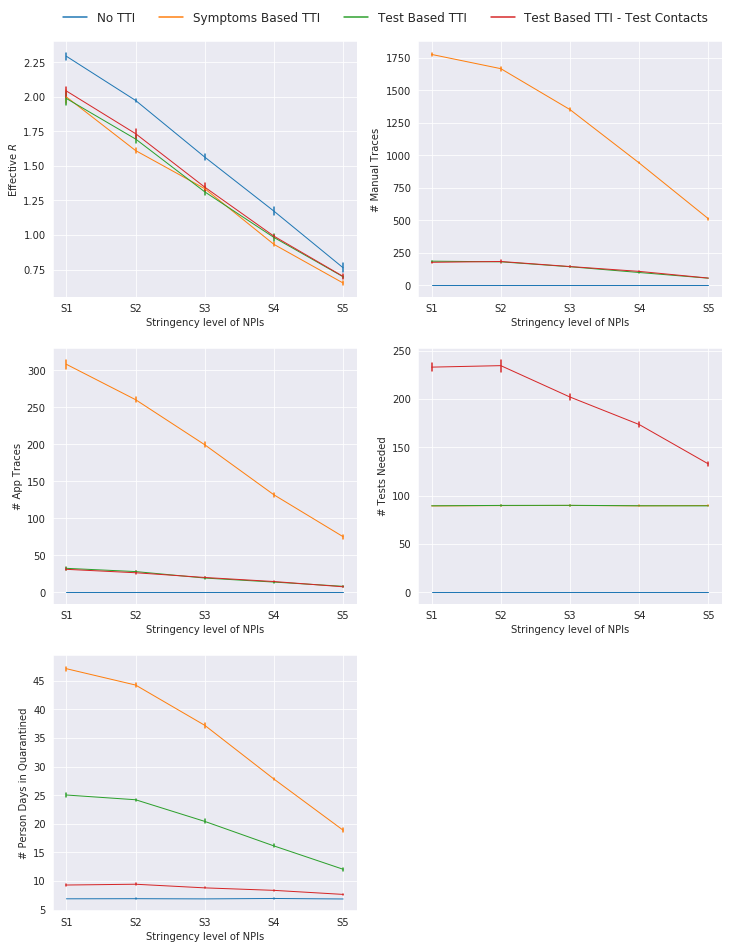

In [62]:
# Plot
fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

# Line plot
sns.lineplot(x="strategy", y="effective_r", data=df_result, 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=68, ax=ax1)
sns.lineplot(x="strategy", y="manual_traces", data=df_result, 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=68, ax=ax2)
sns.lineplot(x="strategy", y="app_traces", data=df_result, 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=68, ax=ax3)
sns.lineplot(x="strategy", y="test_needed", data=df_result, 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=68, ax=ax4)
sns.lineplot(x="strategy", y="persondays_quarantined", data=df_result, 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=68, ax=ax5)

# Display one legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles[1:], labels=["No TTI", "Symptoms Based TTI", "Test Based TTI", "Test Based TTI - Test Contacts"], loc='center left', 
           bbox_to_anchor=(0, 1.09), ncol=4, frameon=False,
          prop={'size': 12})

# Remove legends
for ax in [ax2, ax3, ax4, ax5]:
    legend = ax.legend()
    legend.remove()

# Rename axis
ax1.set_xlabel("Stringency level of NPIs")
ax1.set_ylabel("Effective $R$")


ax2.set_xlabel("Stringency level of NPIs")
ax2.set_ylabel("# Manual Traces")


ax3.set_xlabel("Stringency level of NPIs")
ax3.set_ylabel("# App Traces")


ax4.set_xlabel("Stringency level of NPIs")
ax4.set_ylabel("# Tests Needed")


ax5.set_xlabel("Stringency level of NPIs")
ax5.set_ylabel("# Person Days in Quarantined")

plt.show()

### Age

This section experiments the effect of varying the probability of case being under 18. We aim to see whether under 18 primary case infections is more fatal compared to over 18 primary case infections.

In [9]:
policy_name_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
punder18_params = [0, 0.25, 0.5, 0.75, 1]
n_experiments = 3 # number of simulations performed for a particular value

In [10]:
# Used to store the experimentation result
dict_age = {policy_name: {} for policy_name in policy_name_params}
for punder18_param in punder18_params:
    for key in dict_age.keys():
        dict_age[key][punder18_param] = []

In [11]:
# Try all possible policy and age parameters
for policy_name in tqdm(policy_name_params):
    
    for punder18 in punder18_params:
        case_config["p_under18"] = punder18
        
        # For each case, experiment n times
        for _ in range(n_experiments):
            outputs = do_simulation(policy_name, case_config, contacts_config, n_cases=5000)
            dict_age[policy_name][punder18].append(outputs)

In [46]:
# Save experiment results
filename = "experiments_result/experiment-age"
# save_data(filename, dict_age)

# Load experiment results
dict_age = load_data(filename)

In [47]:
key_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
df_result = {"strategy": [], 
             "gov_policy": [],
             "age_prob": [],
             "effective_r": [], 
             "base_r": [],
             "manual_traces": [], 
             "app_traces": [], 
             "test_needed": [],
             "persondays_quarantined": []}
nppl = 120

for key in key_params:
    strategy = key[:2]
    gov_policy = key[3:]
    
    for punder18 in punder18_params:

        for i in range(n_experiments):
            result_format = pd.DataFrame(dict_age[key][punder18][i]).mean(0)
            df_result["age_prob"].append(punder18)
            df_result["strategy"].append(strategy)
            df_result["gov_policy"].append(gov_policy)
            df_result["effective_r"].append(result_format.loc["Effective R"])
            df_result["base_r"].append(result_format.loc["Base R"])
            df_result["manual_traces"].append(result_format.loc["# Manual Traces"] * nppl)
            df_result["app_traces"].append(result_format.loc["# App Traces"] * nppl)
            df_result["test_needed"].append(result_format.loc["# Tests Needed"] * nppl)
            df_result["persondays_quarantined"].append(result_format.loc["# PersonDays Quarantined"])

In [48]:
# Convert to dataframe
df_result = pd.DataFrame(df_result)

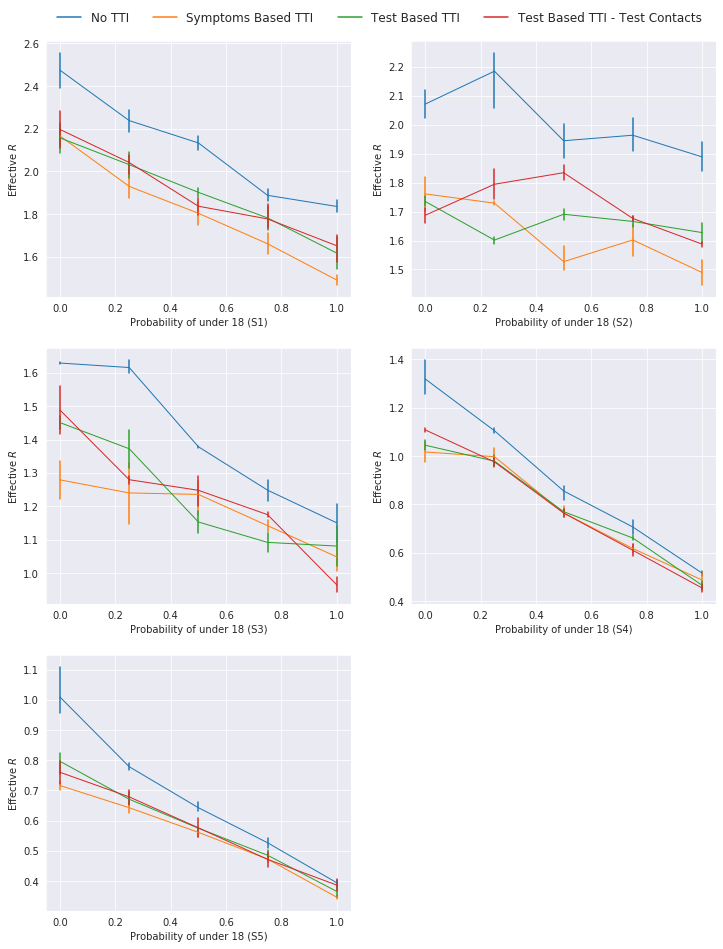

In [49]:
# Plot
fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

# Line plot
sns.lineplot(x="age_prob", y="effective_r", 
             data=df_result[df_result["strategy"] == "S1"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=68, ax=ax1)
sns.lineplot(x="age_prob", y="effective_r", 
             data=df_result[df_result["strategy"] == "S2"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=68, ax=ax2)
sns.lineplot(x="age_prob", y="effective_r", 
             data=df_result[df_result["strategy"] == "S3"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=68, ax=ax3)
sns.lineplot(x="age_prob", y="effective_r", 
             data=df_result[df_result["strategy"] == "S4"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=68, ax=ax4)
sns.lineplot(x="age_prob", y="effective_r", 
             data=df_result[df_result["strategy"] == "S5"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=68, ax=ax5)

# Display one legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles[1:], labels=["No TTI", "Symptoms Based TTI", "Test Based TTI", "Test Based TTI - Test Contacts"], loc='center left', 
           bbox_to_anchor=(0, 1.09), ncol=4, frameon=False,
          prop={'size': 12})

# Remove legends
for ax in [ax2, ax3, ax4, ax5]:
    legend = ax.legend()
    legend.remove()

# Rename axis
ax1.set_xlabel("Probability of under 18 (S1)")
ax1.set_ylabel("Effective $R$")


ax2.set_xlabel("Probability of under 18 (S2)")
ax2.set_ylabel("Effective $R$")


ax3.set_xlabel("Probability of under 18 (S3)")
ax3.set_ylabel("Effective $R$")


ax4.set_xlabel("Probability of under 18 (S4)")
ax4.set_ylabel("Effective $R$")


ax5.set_xlabel("Probability of under 18 (S5)")
ax5.set_ylabel("Effective $R$")

plt.show()

### Compliance

This section experiments the effect of varying the level of compliance on effective R.

In [29]:
policy_name_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
compliance_params = [0.5, 0.6, 0.7, 0.8, 0.9]
n_experiments = 3 # number of simulations performed for a particular value

In [30]:
# Used to store the experimentation result
dict_compliance = {policy_name: {} for policy_name in policy_name_params}
for compliance_param in compliance_params:
    for key in dict_compliance.keys():
        dict_compliance[key][compliance_param] = []

In [50]:
# Try all possible policy and age parameters
for policy_name in tqdm(policy_name_params):
    
    for compliance in compliance_params:
        # For each case, experiment n times
        for _ in range(n_experiments):
            outputs = do_simulation(policy_name, case_config, contacts_config, 
                                    n_cases=5000, dict_params={"compliance": compliance})
            dict_compliance[policy_name][compliance].append(outputs)

In [2]:
# Save experiment results
filename = "experiments_result/experiment-compliance"
save_data(filename, dict_compliance)

# Load experiment results
# dict_compliance = load_data(filename)

In [43]:
key_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
df_result = {"strategy": [], 
             "gov_policy": [],
             "compliance": [],
             "effective_r": [], 
             "base_r": [],
             "manual_traces": [], 
             "app_traces": [], 
             "test_needed": [],
             "persondays_quarantined": []}
nppl = 120

for key in key_params:
    strategy = key[:2]
    gov_policy = key[3:]
    
    for compliance in compliance_params:

        for i in range(n_experiments):
            result_format = pd.DataFrame(dict_compliance[key][compliance][i]).mean(0)
            df_result["compliance"].append(compliance)
            df_result["strategy"].append(strategy)
            df_result["gov_policy"].append(gov_policy)
            df_result["effective_r"].append(result_format.loc["Effective R"])
            df_result["base_r"].append(result_format.loc["Base R"])
            df_result["manual_traces"].append(result_format.loc["# Manual Traces"] * nppl)
            df_result["app_traces"].append(result_format.loc["# App Traces"] * nppl)
            df_result["test_needed"].append(result_format.loc["# Tests Needed"] * nppl)
            df_result["persondays_quarantined"].append(result_format.loc["# PersonDays Quarantined"])

In [44]:
# Convert to dataframe
df_result = pd.DataFrame(df_result)

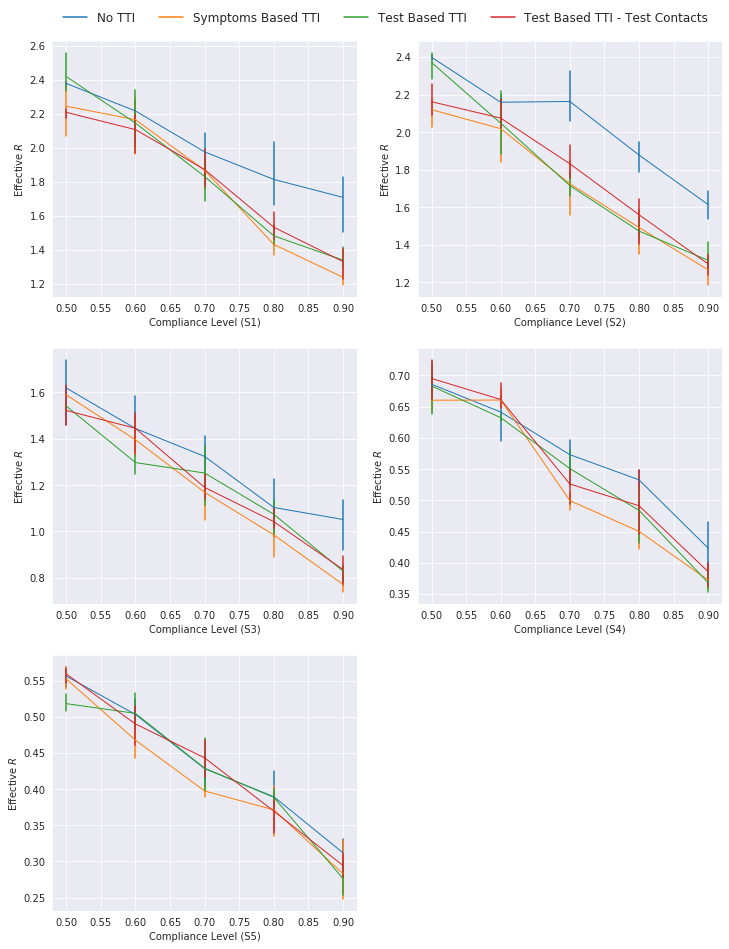

In [45]:
# Plot
fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

# Line plot
sns.lineplot(x="compliance", y="effective_r", 
             data=df_result[df_result["strategy"] == "S1"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax1)
sns.lineplot(x="compliance", y="effective_r", 
             data=df_result[df_result["strategy"] == "S2"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax2)
sns.lineplot(x="compliance", y="effective_r", 
             data=df_result[df_result["strategy"] == "S3"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax3)
sns.lineplot(x="compliance", y="effective_r", 
             data=df_result[df_result["strategy"] == "S4"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax4)
sns.lineplot(x="compliance", y="effective_r", 
             data=df_result[df_result["strategy"] == "S5"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax5)

# Display one legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles[1:], labels=["No TTI", "Symptoms Based TTI", "Test Based TTI", "Test Based TTI - Test Contacts"], loc='center left', 
           bbox_to_anchor=(0, 1.09), ncol=4, frameon=False,
          prop={'size': 12})

# Remove legends
for ax in [ax2, ax3, ax4, ax5]:
    legend = ax.legend()
    legend.remove()

# Rename axis
ax1.set_xlabel("Compliance Level (S1)")
ax1.set_ylabel("Effective $R$")


ax2.set_xlabel("Compliance Level (S2)")
ax2.set_ylabel("Effective $R$")


ax3.set_xlabel("Compliance Level (S3)")
ax3.set_ylabel("Effective $R$")


ax4.set_xlabel("Compliance Level (S4)")
ax4.set_ylabel("Effective $R$")


ax5.set_xlabel("Compliance Level (S5)")
ax5.set_ylabel("Effective $R$")

plt.show()

### Application Uptake

This section experiments the effect of varying the level of compliance on effective R.

In [19]:
policy_name_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
app_params = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
n_experiments = 2 # number of simulations performed for a particular value

In [21]:
# Used to store the experimentation result
dict_app = {policy_name: {} for policy_name in policy_name_params}
for app_param in app_params:
    for key in dict_app.keys():
        dict_app[key][app_param] = []

In [22]:
# Try all possible policy and age parameters
for policy_name in tqdm(policy_name_params):
    
    for app in app_params:
        # For each case, experiment n times
        for _ in range(n_experiments):
            outputs = do_simulation(policy_name, case_config, contacts_config, 
                                    n_cases=5000, dict_params={"app_cov": app})
            dict_app[policy_name][app].append(outputs)

In [2]:
# Save experiment results
filename = "experiments_result/experiment-app"
save_data(filename, dict_app)

# Load experiment results
# dict_compliance = load_data(filename)

In [23]:
key_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
df_result = {"strategy": [], 
             "gov_policy": [],
             "app": [],
             "effective_r": [], 
             "base_r": [],
             "manual_traces": [], 
             "app_traces": [], 
             "test_needed": [],
             "persondays_quarantined": []}
nppl = 120

for key in key_params:
    strategy = key[:2]
    gov_policy = key[3:]
    
    for app in app_params:

        for i in range(n_experiments):
            result_format = pd.DataFrame(dict_app[key][app][i]).mean(0)
            df_result["app"].append(app)
            df_result["strategy"].append(strategy)
            df_result["gov_policy"].append(gov_policy)
            df_result["effective_r"].append(result_format.loc["Effective R"])
            df_result["base_r"].append(result_format.loc["Base R"])
            df_result["manual_traces"].append(result_format.loc["# Manual Traces"] * nppl)
            df_result["app_traces"].append(result_format.loc["# App Traces"] * nppl)
            df_result["test_needed"].append(result_format.loc["# Tests Needed"] * nppl)
            df_result["persondays_quarantined"].append(result_format.loc["# PersonDays Quarantined"])

In [24]:
# Convert to dataframe
df_result = pd.DataFrame(df_result)

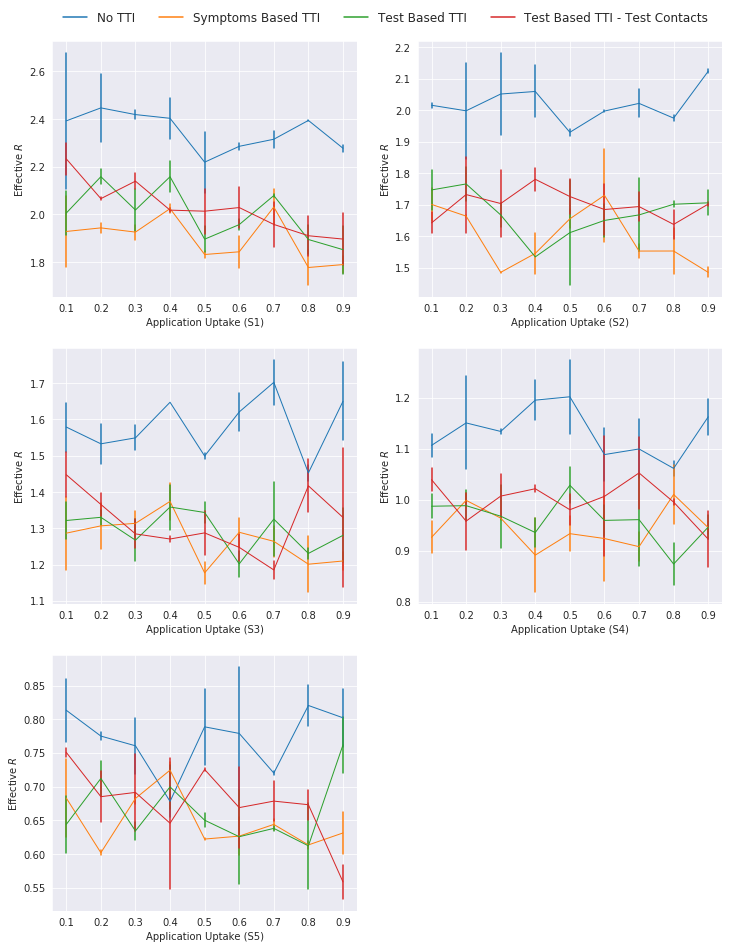

In [25]:
# Plot
fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

# Line plot
sns.lineplot(x="app", y="effective_r", 
             data=df_result[df_result["strategy"] == "S1"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax1)
sns.lineplot(x="app", y="effective_r", 
             data=df_result[df_result["strategy"] == "S2"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax2)
sns.lineplot(x="app", y="effective_r", 
             data=df_result[df_result["strategy"] == "S3"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax3)
sns.lineplot(x="app", y="effective_r", 
             data=df_result[df_result["strategy"] == "S4"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax4)
sns.lineplot(x="app", y="effective_r", 
             data=df_result[df_result["strategy"] == "S5"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax5)

# Display one legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles[1:], labels=["No TTI", "Symptoms Based TTI", "Test Based TTI", "Test Based TTI - Test Contacts"], loc='center left', 
           bbox_to_anchor=(0, 1.09), ncol=4, frameon=False,
          prop={'size': 12})

# Remove legends
for ax in [ax2, ax3, ax4, ax5]:
    legend = ax.legend()
    legend.remove()

# Rename axis
ax1.set_xlabel("Application Uptake (S1)")
ax1.set_ylabel("Effective $R$")


ax2.set_xlabel("Application Uptake (S2)")
ax2.set_ylabel("Effective $R$")


ax3.set_xlabel("Application Uptake (S3)")
ax3.set_ylabel("Effective $R$")


ax4.set_xlabel("Application Uptake (S4)")
ax4.set_ylabel("Effective $R$")


ax5.set_xlabel("Application Uptake (S5)")
ax5.set_ylabel("Effective $R$")

plt.show()

### Do Manual Tracing

This section experiments the effect of performing or not performing manual tracing.

In [29]:
policy_name_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
manual_tracing_params = [True, False]
n_experiments = 5 # number of simulations performed for a particular value

In [30]:
# Used to store the experimentation result
dict_mt = {policy_name: {} for policy_name in policy_name_params}
for manual_tracing_param in manual_tracing_params:
    for key in dict_mt.keys():
        dict_mt[key][manual_tracing_param] = []

In [31]:
# Try all possible policy and age parameters
for policy_name in tqdm(policy_name_params):
    
    for mt in manual_tracing_params:
        # For each case, experiment n times
        for _ in range(n_experiments):
            outputs = do_simulation(policy_name, case_config, contacts_config, 
                                    n_cases=5000, dict_params={"do_manual_tracing": mt})
            dict_mt[policy_name][mt].append(outputs)

In [2]:
# Save experiment results
filename = "experiments_result/experiment-manual_tracing"
save_data(filename, dict_mt)

# Load experiment results
# dict_compliance = load_data(filename)

In [35]:
key_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
df_result = {"strategy": [], 
             "gov_policy": [],
             "do_mt": [],
             "effective_r": [], 
             "base_r": [],
             "manual_traces": [], 
             "app_traces": [], 
             "test_needed": [],
             "persondays_quarantined": []}
nppl = 120

for key in key_params:
    strategy = key[:2]
    gov_policy = key[3:]
    
    for mt in manual_tracing_params:

        for i in range(n_experiments):
            result_format = pd.DataFrame(dict_mt[key][mt][i]).mean(0)
            df_result["do_mt"].append(mt)
            df_result["strategy"].append(strategy)
            df_result["gov_policy"].append(gov_policy)
            df_result["effective_r"].append(result_format.loc["Effective R"])
            df_result["base_r"].append(result_format.loc["Base R"])
            df_result["manual_traces"].append(result_format.loc["# Manual Traces"] * nppl)
            df_result["app_traces"].append(result_format.loc["# App Traces"] * nppl)
            df_result["test_needed"].append(result_format.loc["# Tests Needed"] * nppl)
            df_result["persondays_quarantined"].append(result_format.loc["# PersonDays Quarantined"])

In [36]:
# Convert to dataframe
df_result = pd.DataFrame(df_result)

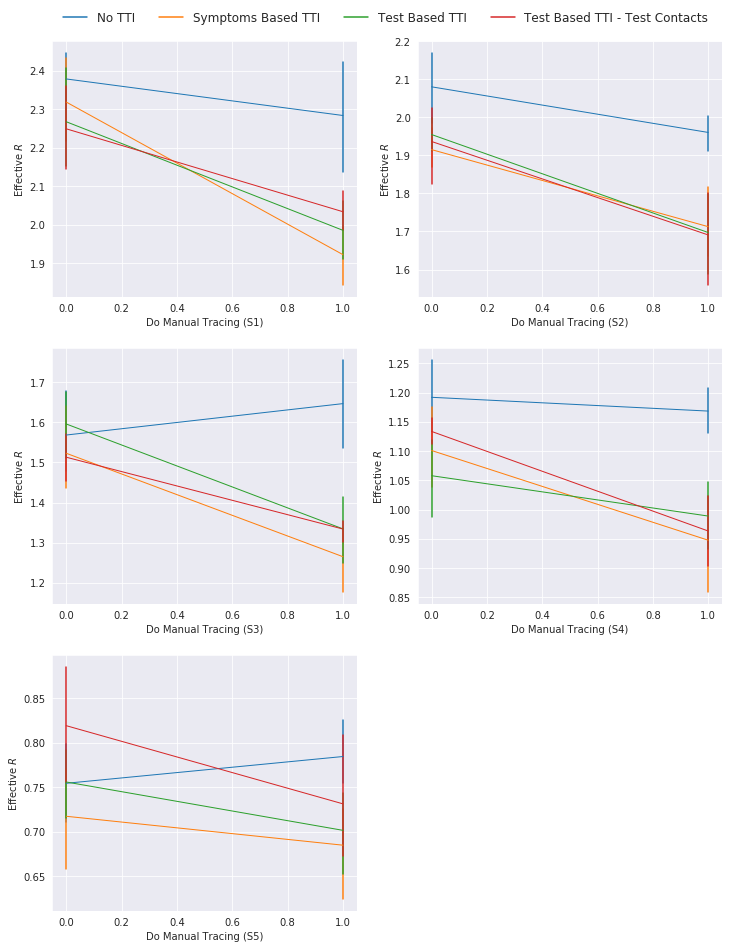

In [37]:
# Plot
fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

# Line plot
sns.lineplot(x="do_mt", y="effective_r", 
             data=df_result[df_result["strategy"] == "S1"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax1)
sns.lineplot(x="do_mt", y="effective_r", 
             data=df_result[df_result["strategy"] == "S2"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax2)
sns.lineplot(x="do_mt", y="effective_r", 
             data=df_result[df_result["strategy"] == "S3"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax3)
sns.lineplot(x="do_mt", y="effective_r", 
             data=df_result[df_result["strategy"] == "S4"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax4)
sns.lineplot(x="do_mt", y="effective_r", 
             data=df_result[df_result["strategy"] == "S5"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax5)

# Display one legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles[1:], labels=["No TTI", "Symptoms Based TTI", "Test Based TTI", "Test Based TTI - Test Contacts"], loc='center left', 
           bbox_to_anchor=(0, 1.09), ncol=4, frameon=False,
          prop={'size': 12})

# Remove legends
for ax in [ax2, ax3, ax4, ax5]:
    legend = ax.legend()
    legend.remove()

# Rename axis
ax1.set_xlabel("Do Manual Tracing (S1)")
ax1.set_ylabel("Effective $R$")


ax2.set_xlabel("Do Manual Tracing (S2)")
ax2.set_ylabel("Effective $R$")


ax3.set_xlabel("Do Manual Tracing (S3)")
ax3.set_ylabel("Effective $R$")


ax4.set_xlabel("Do Manual Tracing (S4)")
ax4.set_ylabel("Effective $R$")


ax5.set_xlabel("Do Manual Tracing (S5)")
ax5.set_ylabel("Effective $R$")

plt.show()

### Do App Tracing

This section experiments the effect of performing or not performing app tracing.

In [38]:
policy_name_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
app_tracing_params = [True, False]
n_experiments = 5 # number of simulations performed for a particular value

In [39]:
# Used to store the experimentation result
dict_at = {policy_name: {} for policy_name in policy_name_params}
for app_tracing_param in app_tracing_params:
    for key in dict_at.keys():
        dict_at[key][app_tracing_param] = []

In [40]:
# Try all possible policy and age parameters
for policy_name in tqdm(policy_name_params):
    
    for at in app_tracing_params:
        # For each case, experiment n times
        for _ in range(n_experiments):
            outputs = do_simulation(policy_name, case_config, contacts_config, 
                                    n_cases=5000, dict_params={"do_app_tracing": at})
            dict_at[policy_name][at].append(outputs)

In [2]:
# Save experiment results
filename = "experiments_result/experiment-app-tracing"
save_data(filename, dict_mt)

# Load experiment results
# dict_compliance = load_data(filename)

In [44]:
key_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
df_result = {"strategy": [], 
             "gov_policy": [],
             "do_at": [],
             "effective_r": [], 
             "base_r": [],
             "manual_traces": [], 
             "app_traces": [], 
             "test_needed": [],
             "persondays_quarantined": []}
nppl = 120

for key in key_params:
    strategy = key[:2]
    gov_policy = key[3:]
    
    for at in app_tracing_params:

        for i in range(n_experiments):
            result_format = pd.DataFrame(dict_at[key][at][i]).mean(0)
            df_result["do_at"].append(at)
            df_result["strategy"].append(strategy)
            df_result["gov_policy"].append(gov_policy)
            df_result["effective_r"].append(result_format.loc["Effective R"])
            df_result["base_r"].append(result_format.loc["Base R"])
            df_result["manual_traces"].append(result_format.loc["# Manual Traces"] * nppl)
            df_result["app_traces"].append(result_format.loc["# App Traces"] * nppl)
            df_result["test_needed"].append(result_format.loc["# Tests Needed"] * nppl)
            df_result["persondays_quarantined"].append(result_format.loc["# PersonDays Quarantined"])

In [45]:
# Convert to dataframe
df_result = pd.DataFrame(df_result)

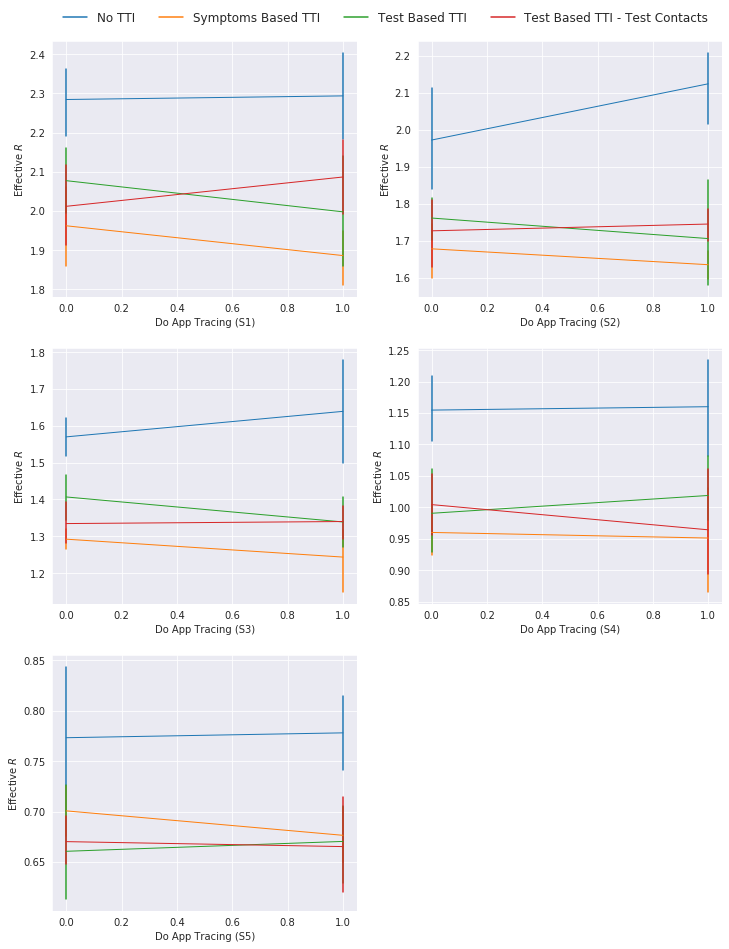

In [46]:
# Plot
fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

# Line plot
sns.lineplot(x="do_at", y="effective_r", 
             data=df_result[df_result["strategy"] == "S1"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax1)
sns.lineplot(x="do_at", y="effective_r", 
             data=df_result[df_result["strategy"] == "S2"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax2)
sns.lineplot(x="do_at", y="effective_r", 
             data=df_result[df_result["strategy"] == "S3"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax3)
sns.lineplot(x="do_at", y="effective_r", 
             data=df_result[df_result["strategy"] == "S4"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax4)
sns.lineplot(x="do_at", y="effective_r", 
             data=df_result[df_result["strategy"] == "S5"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax5)

# Display one legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles[1:], labels=["No TTI", "Symptoms Based TTI", "Test Based TTI", "Test Based TTI - Test Contacts"], loc='center left', 
           bbox_to_anchor=(0, 1.09), ncol=4, frameon=False,
          prop={'size': 12})

# Remove legends
for ax in [ax2, ax3, ax4, ax5]:
    legend = ax.legend()
    legend.remove()

# Rename axis
ax1.set_xlabel("Do App Tracing (S1)")
ax1.set_ylabel("Effective $R$")


ax2.set_xlabel("Do App Tracing (S2)")
ax2.set_ylabel("Effective $R$")


ax3.set_xlabel("Do App Tracing (S3)")
ax3.set_ylabel("Effective $R$")


ax4.set_xlabel("Do App Tracing (S4)")
ax4.set_ylabel("Effective $R$")


ax5.set_xlabel("Do App Tracing (S5)")
ax5.set_ylabel("Effective $R$")

plt.show()

### Day of Symptoms Reporting

This section experiments the effect of varying the days of symptoms reporting.

In [50]:
policy_name_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
symptoms_reporting_params = [[1, 0 , 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]
n_experiments = 3 # number of simulations performed for a particular value

In [51]:
# Used to store the experimentation result
dict_symptoms_reporting = {policy_name: {} for policy_name in policy_name_params}
for i, symptoms_reporting_param in enumerate(symptoms_reporting_params):
    for key in dict_symptoms_reporting.keys():
        dict_symptoms_reporting[key][i+1] = []

In [52]:
# Try all possible policy and age parameters
for policy_name in tqdm(policy_name_params):
    
    for i, symptoms_reporting_param in enumerate(symptoms_reporting_params):
        case_config["p_day_noticed_symptoms"] = symptoms_reporting_param
        
        # For each case, experiment n times
        for _ in range(n_experiments):
            outputs = do_simulation(policy_name, case_config, contacts_config, n_cases=5000)
            dict_symptoms_reporting[policy_name][i+1].append(outputs)

In [46]:
# Save experiment results
# filename = "experiments_result/experiment-symptoms"
# save_data(filename, dict_age)

# Load experiment results
# dict_age = load_data(filename)

In [55]:
key_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
df_result = {"strategy": [], 
             "gov_policy": [],
             "days_symptoms_reporting": [],
             "effective_r": [], 
             "base_r": [],
             "manual_traces": [], 
             "app_traces": [], 
             "test_needed": [],
             "persondays_quarantined": []}
nppl = 120

for key in key_params:
    strategy = key[:2]
    gov_policy = key[3:]
    
    for j, symptoms_reporting_param in enumerate(symptoms_reporting_params):

        for i in range(n_experiments):
            result_format = pd.DataFrame(dict_symptoms_reporting[key][j+1][i]).mean(0)
            df_result["days_symptoms_reporting"].append(j+1)
            df_result["strategy"].append(strategy)
            df_result["gov_policy"].append(gov_policy)
            df_result["effective_r"].append(result_format.loc["Effective R"])
            df_result["base_r"].append(result_format.loc["Base R"])
            df_result["manual_traces"].append(result_format.loc["# Manual Traces"] * nppl)
            df_result["app_traces"].append(result_format.loc["# App Traces"] * nppl)
            df_result["test_needed"].append(result_format.loc["# Tests Needed"] * nppl)
            df_result["persondays_quarantined"].append(result_format.loc["# PersonDays Quarantined"])

In [56]:
# Convert to dataframe
df_result = pd.DataFrame(df_result)

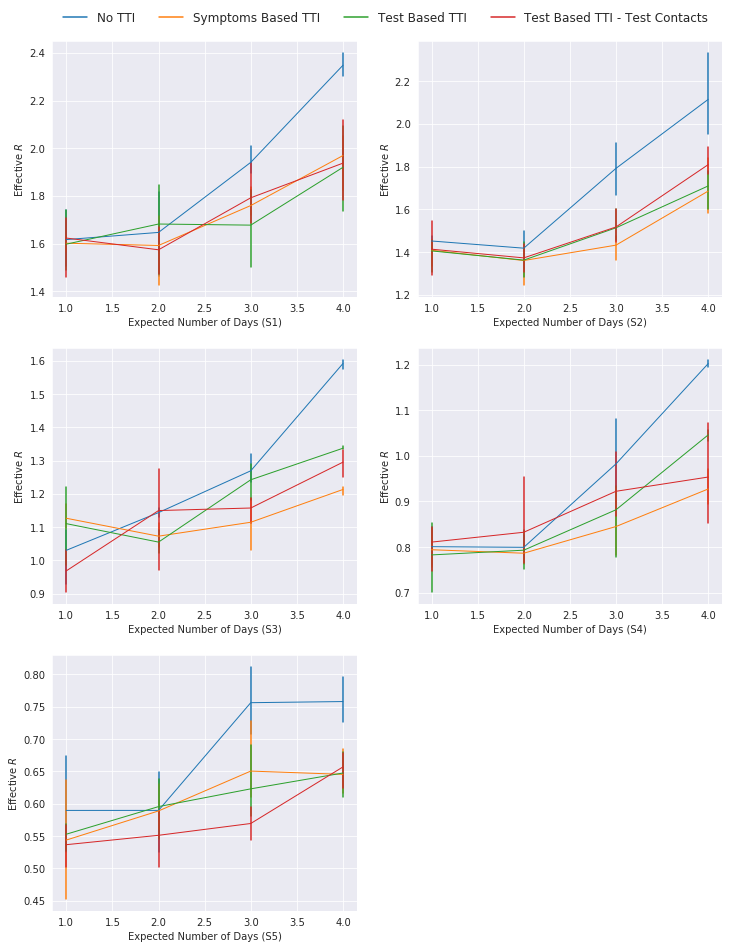

In [59]:
# Plot
fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

# Line plot
sns.lineplot(x="days_symptoms_reporting", y="effective_r", 
             data=df_result[df_result["strategy"] == "S1"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=99, ax=ax1)
sns.lineplot(x="days_symptoms_reporting", y="effective_r", 
             data=df_result[df_result["strategy"] == "S2"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=99, ax=ax2)
sns.lineplot(x="days_symptoms_reporting", y="effective_r", 
             data=df_result[df_result["strategy"] == "S3"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=99, ax=ax3)
sns.lineplot(x="days_symptoms_reporting", y="effective_r", 
             data=df_result[df_result["strategy"] == "S4"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=99, ax=ax4)
sns.lineplot(x="days_symptoms_reporting", y="effective_r", 
             data=df_result[df_result["strategy"] == "S5"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=99, ax=ax5)

# Display one legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles[1:], labels=["No TTI", "Symptoms Based TTI", "Test Based TTI", "Test Based TTI - Test Contacts"], loc='center left', 
           bbox_to_anchor=(0, 1.09), ncol=4, frameon=False,
          prop={'size': 12})

# Remove legends
for ax in [ax2, ax3, ax4, ax5]:
    legend = ax.legend()
    legend.remove()

# Rename axis
ax1.set_xlabel("Expected Number of Days (S1)")
ax1.set_ylabel("Effective $R$")


ax2.set_xlabel("Expected Number of Days (S2)")
ax2.set_ylabel("Effective $R$")


ax3.set_xlabel("Expected Number of Days (S3)")
ax3.set_ylabel("Effective $R$")


ax4.set_xlabel("Expected Number of Days (S4)")
ax4.set_ylabel("Effective $R$")


ax5.set_xlabel("Expected Number of Days (S5)")
ax5.set_ylabel("Effective $R$")

plt.show()

### Latent Period

This section experiments the effect of latent period to effective R.

In [8]:
policy_name_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
latent_params = [1, 2, 3, 4]
n_experiments = 3 # number of simulations performed for a particular value

In [9]:
# Used to store the experimentation result
dict_latent = {policy_name: {} for policy_name in policy_name_params}
for latent_param in latent_params:
    for key in dict_latent.keys():
        dict_latent[key][latent_param] = []

In [10]:
# Try all possible policy and age parameters
for policy_name in tqdm(policy_name_params):
    
    for latent in latent_params:
        # For each case, experiment n times
        for _ in range(n_experiments):
            outputs = do_simulation(policy_name, case_config, contacts_config, 
                                    n_cases=5000, dict_params={"latent_period": latent})
            dict_latent[policy_name][latent].append(outputs)

In [2]:
# Save experiment results
# filename = "experiments_result/experiment-app-tracing"
# save_data(filename, dict_mt)

# Load experiment results
# dict_compliance = load_data(filename)

In [11]:
key_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
df_result = {"strategy": [], 
             "gov_policy": [],
             "latent_period": [],
             "effective_r": [], 
             "base_r": [],
             "manual_traces": [], 
             "app_traces": [], 
             "test_needed": [],
             "persondays_quarantined": []}
nppl = 120

for key in key_params:
    strategy = key[:2]
    gov_policy = key[3:]
    
    for latent in latent_params:

        for i in range(n_experiments):
            result_format = pd.DataFrame(dict_latent[key][latent][i]).mean(0)
            df_result["latent_period"].append(latent)
            df_result["strategy"].append(strategy)
            df_result["gov_policy"].append(gov_policy)
            df_result["effective_r"].append(result_format.loc["Effective R"])
            df_result["base_r"].append(result_format.loc["Base R"])
            df_result["manual_traces"].append(result_format.loc["# Manual Traces"] * nppl)
            df_result["app_traces"].append(result_format.loc["# App Traces"] * nppl)
            df_result["test_needed"].append(result_format.loc["# Tests Needed"] * nppl)
            df_result["persondays_quarantined"].append(result_format.loc["# PersonDays Quarantined"])

In [12]:
# Convert to dataframe
df_result = pd.DataFrame(df_result)

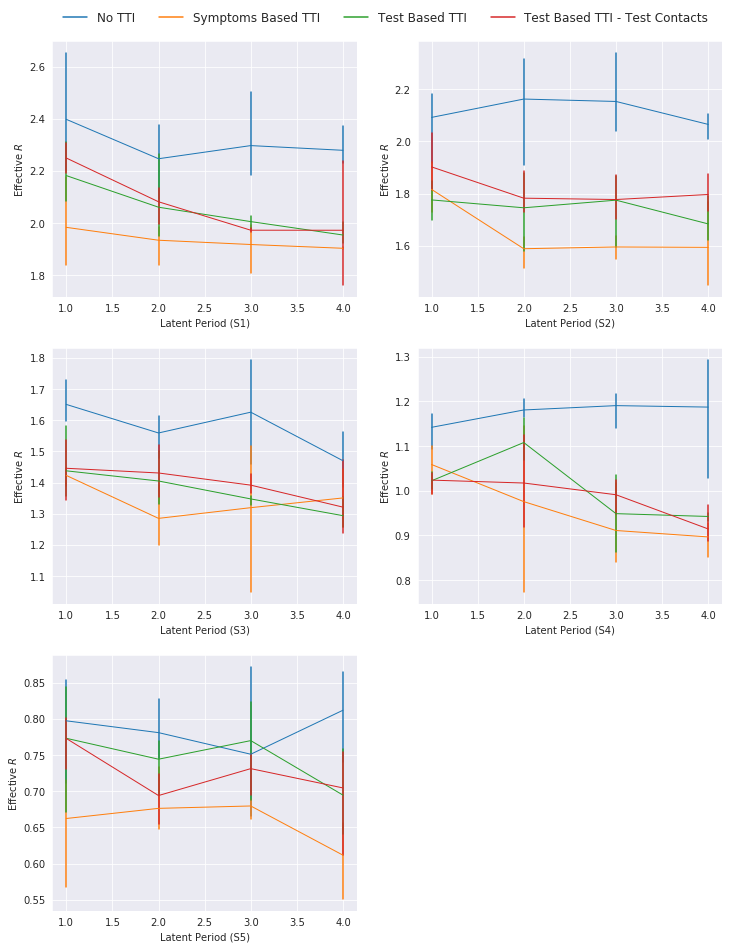

In [13]:
# Plot
fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

# Line plot
sns.lineplot(x="latent_period", y="effective_r", 
             data=df_result[df_result["strategy"] == "S1"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax1)
sns.lineplot(x="latent_period", y="effective_r", 
             data=df_result[df_result["strategy"] == "S2"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax2)
sns.lineplot(x="latent_period", y="effective_r", 
             data=df_result[df_result["strategy"] == "S3"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax3)
sns.lineplot(x="latent_period", y="effective_r", 
             data=df_result[df_result["strategy"] == "S4"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax4)
sns.lineplot(x="latent_period", y="effective_r", 
             data=df_result[df_result["strategy"] == "S5"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax5)

# Display one legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles[1:], labels=["No TTI", "Symptoms Based TTI", "Test Based TTI", "Test Based TTI - Test Contacts"], loc='center left', 
           bbox_to_anchor=(0, 1.09), ncol=4, frameon=False,
          prop={'size': 12})

# Remove legends
for ax in [ax2, ax3, ax4, ax5]:
    legend = ax.legend()
    legend.remove()

# Rename axis
ax1.set_xlabel("Latent Period (S1)")
ax1.set_ylabel("Effective $R$")


ax2.set_xlabel("Latent Period (S2)")
ax2.set_ylabel("Effective $R$")


ax3.set_xlabel("Latent Period (S3)")
ax3.set_ylabel("Effective $R$")


ax4.set_xlabel("Latent Period (S4)")
ax4.set_ylabel("Effective $R$")


ax5.set_xlabel("Latent Period (S5)")
ax5.set_ylabel("Effective $R$")

plt.show()

### Most Infectious Day

This section experiments the effect of varying the most infectious period for COVID cases on R.

In [8]:
policy_name_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
most_infectious_params = [[1, 0 , 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]
n_experiments = 3 # number of simulations performed for a particular value

In [9]:
# Used to store the experimentation result
dict_most_infectious = {policy_name: {} for policy_name in policy_name_params}
for i, most_infectious_param in enumerate(most_infectious_params):
    for key in dict_most_infectious.keys():
        dict_most_infectious[key][i+1] = []

In [10]:
# Try all possible policy and age parameters
for policy_name in tqdm(policy_name_params):
    
    for i, most_infectious_param in enumerate(most_infectious_params):
        case_config["inf_profile"] = most_infectious_param
        
        # For each case, experiment n times
        for _ in range(n_experiments):
            outputs = do_simulation(policy_name, case_config, contacts_config, n_cases=5000)
            dict_most_infectious[policy_name][i+1].append(outputs)

In [46]:
# Save experiment results
# filename = "experiments_result/experiment-symptoms"
# save_data(filename, dict_age)

# Load experiment results
# dict_age = load_data(filename)

In [12]:
key_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
df_result = {"strategy": [], 
             "gov_policy": [],
             "days_most_infectious": [],
             "effective_r": [], 
             "base_r": [],
             "manual_traces": [], 
             "app_traces": [], 
             "test_needed": [],
             "persondays_quarantined": []}
nppl = 120

for key in key_params:
    strategy = key[:2]
    gov_policy = key[3:]
    
    for j, most_infectious_param in enumerate(most_infectious_params):

        for i in range(n_experiments):
            result_format = pd.DataFrame(dict_most_infectious[key][j+1][i]).mean(0)
            df_result["days_most_infectious"].append(j+1)
            df_result["strategy"].append(strategy)
            df_result["gov_policy"].append(gov_policy)
            df_result["effective_r"].append(result_format.loc["Effective R"])
            df_result["base_r"].append(result_format.loc["Base R"])
            df_result["manual_traces"].append(result_format.loc["# Manual Traces"] * nppl)
            df_result["app_traces"].append(result_format.loc["# App Traces"] * nppl)
            df_result["test_needed"].append(result_format.loc["# Tests Needed"] * nppl)
            df_result["persondays_quarantined"].append(result_format.loc["# PersonDays Quarantined"])

In [13]:
# Convert to dataframe
df_result = pd.DataFrame(df_result)

In [15]:
# df_result.to_csv("experiments_result/test.csv", index=False)

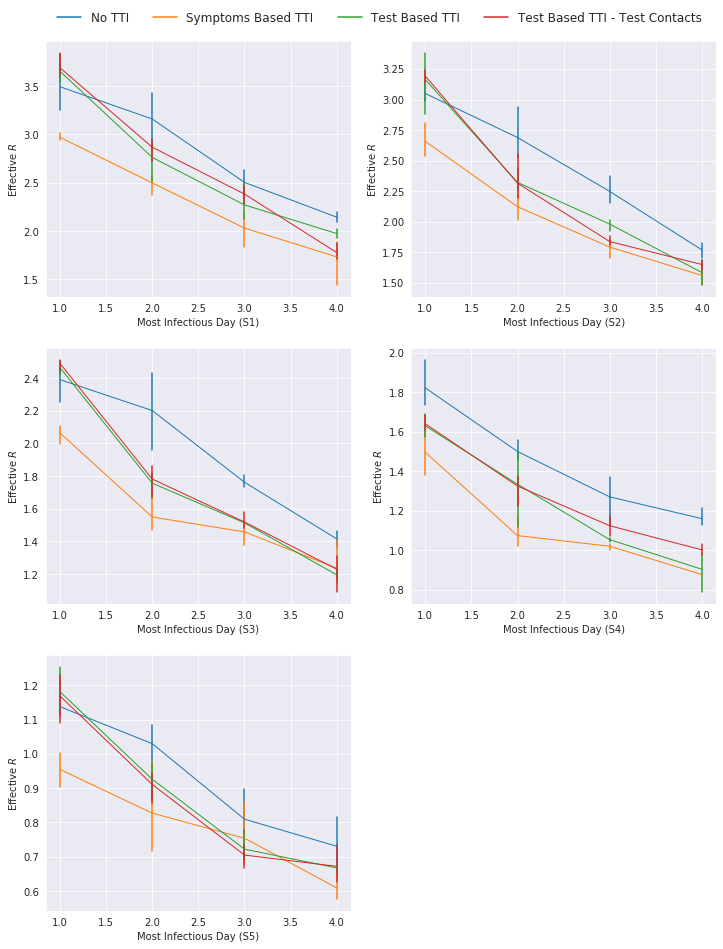

In [14]:
# Plot
fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

# Line plot
sns.lineplot(x="days_most_infectious", y="effective_r", 
             data=df_result[df_result["strategy"] == "S1"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=99, ax=ax1)
sns.lineplot(x="days_most_infectious", y="effective_r", 
             data=df_result[df_result["strategy"] == "S2"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=99, ax=ax2)
sns.lineplot(x="days_most_infectious", y="effective_r", 
             data=df_result[df_result["strategy"] == "S3"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=99, ax=ax3)
sns.lineplot(x="days_most_infectious", y="effective_r", 
             data=df_result[df_result["strategy"] == "S4"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=99, ax=ax4)
sns.lineplot(x="days_most_infectious", y="effective_r", 
             data=df_result[df_result["strategy"] == "S5"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=99, ax=ax5)

# Display one legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles[1:], labels=["No TTI", "Symptoms Based TTI", "Test Based TTI", "Test Based TTI - Test Contacts"], loc='center left', 
           bbox_to_anchor=(0, 1.09), ncol=4, frameon=False,
          prop={'size': 12})

# Remove legends
for ax in [ax2, ax3, ax4, ax5]:
    legend = ax.legend()
    legend.remove()

# Rename axis
ax1.set_xlabel("Most Infectious Day (S1)")
ax1.set_ylabel("Effective $R$")


ax2.set_xlabel("Most Infectious Day (S2)")
ax2.set_ylabel("Effective $R$")


ax3.set_xlabel("Most Infectious Day (S3)")
ax3.set_ylabel("Effective $R$")


ax4.set_xlabel("Most Infectious Day (S4)")
ax4.set_ylabel("Effective $R$")


ax5.set_xlabel("Most Infectious Day (S5)")
ax5.set_ylabel("Effective $R$")

plt.show()

### WFH

This section experiments the effect of work from home to effective R.

In [22]:
policy_name_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
wfh_params = [0, 0.25, 0.5, 0.75, 1]
n_experiments = 2 # number of simulations performed for a particular value

In [23]:
# Used to store the experimentation result
dict_wfh = {policy_name: {} for policy_name in policy_name_params}
for wfh_param in wfh_params:
    for key in dict_wfh.keys():
        dict_wfh[key][wfh_param] = []

In [24]:
# Try all possible policy and age parameters
for policy_name in tqdm(policy_name_params):
    
    for wfh_param in wfh_params:
        # For each case, experiment n times
        for _ in range(n_experiments):
            outputs = do_simulation(policy_name, case_config, contacts_config, 
                                    n_cases=20000, dict_params={"wfh_prob": wfh_param})
            dict_wfh[policy_name][wfh_param].append(outputs)

In [2]:
# Save experiment results
# filename = "experiments_result/experiment-app-tracing"
# save_data(filename, dict_mt)

# Load experiment results
# dict_compliance = load_data(filename)

In [25]:
key_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
df_result = {"strategy": [], 
             "gov_policy": [],
             "wfh": [],
             "effective_r": [], 
             "base_r": [],
             "manual_traces": [], 
             "app_traces": [], 
             "test_needed": [],
             "persondays_quarantined": []}
nppl = 120

for key in key_params:
    strategy = key[:2]
    gov_policy = key[3:]
    
    for wfh in wfh_params:

        for i in range(n_experiments):
            result_format = pd.DataFrame(dict_wfh[key][wfh][i]).mean(0)
            df_result["wfh"].append(wfh)
            df_result["strategy"].append(strategy)
            df_result["gov_policy"].append(gov_policy)
            df_result["effective_r"].append(result_format.loc["Effective R"])
            df_result["base_r"].append(result_format.loc["Base R"])
            df_result["manual_traces"].append(result_format.loc["# Manual Traces"] * nppl)
            df_result["app_traces"].append(result_format.loc["# App Traces"] * nppl)
            df_result["test_needed"].append(result_format.loc["# Tests Needed"] * nppl)
            df_result["persondays_quarantined"].append(result_format.loc["# PersonDays Quarantined"])

In [26]:
# Convert to dataframe
df_result = pd.DataFrame(df_result)

In [29]:
df_result.to_csv("experiments_result/test.csv", index=False)

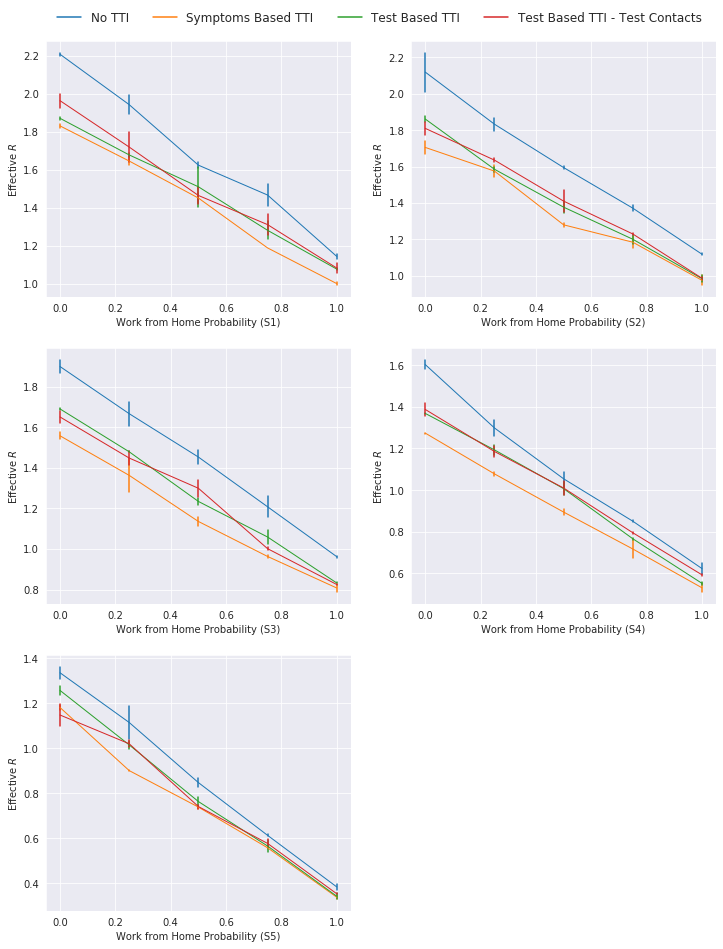

In [28]:
# Plot
fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

# Line plot
sns.lineplot(x="wfh", y="effective_r", 
             data=df_result[df_result["strategy"] == "S1"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax1)
sns.lineplot(x="wfh", y="effective_r", 
             data=df_result[df_result["strategy"] == "S2"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax2)
sns.lineplot(x="wfh", y="effective_r", 
             data=df_result[df_result["strategy"] == "S3"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax3)
sns.lineplot(x="wfh", y="effective_r", 
             data=df_result[df_result["strategy"] == "S4"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax4)
sns.lineplot(x="wfh", y="effective_r", 
             data=df_result[df_result["strategy"] == "S5"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=68, ax=ax5)

# Display one legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles[1:], labels=["No TTI", "Symptoms Based TTI", "Test Based TTI", "Test Based TTI - Test Contacts"], loc='center left', 
           bbox_to_anchor=(0, 1.09), ncol=4, frameon=False,
          prop={'size': 12})

# Remove legends
for ax in [ax2, ax3, ax4, ax5]:
    legend = ax.legend()
    legend.remove()

# Rename axis
ax1.set_xlabel("Work from Home Probability (S1)")
ax1.set_ylabel("Effective $R$")


ax2.set_xlabel("Work from Home Probability (S2)")
ax2.set_ylabel("Effective $R$")


ax3.set_xlabel("Work from Home Probability (S3)")
ax3.set_ylabel("Effective $R$")


ax4.set_xlabel("Work from Home Probability (S4)")
ax4.set_ylabel("Effective $R$")


ax5.set_xlabel("Work from Home Probability (S5)")
ax5.set_ylabel("Effective $R$")

plt.show()

### Go to School

This section experiments the effect of go to school probability to effective R.

In [8]:
policy_name_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
gts_params = [0, 0.25, 0.5, 0.75, 1]
n_experiments = 2 # number of simulations performed for a particular value

In [9]:
# Used to store the experimentation result
dict_gts = {policy_name: {} for policy_name in policy_name_params}
for gts_param in gts_params:
    for key in dict_gts.keys():
        dict_gts[key][gts_param] = []

In [10]:
# Try all possible policy and age parameters
for policy_name in tqdm(policy_name_params):
    
    for gts_param in gts_params:
        # For each case, experiment n times
        for _ in range(n_experiments):
            outputs = do_simulation(policy_name, case_config, contacts_config, 
                                    n_cases=15000, dict_params={"go_to_school_prob": gts_param})
            dict_gts[policy_name][gts_param].append(outputs)

In [2]:
# Save experiment results
# filename = "experiments_result/experiment-app-tracing"
# save_data(filename, dict_mt)

# Load experiment results
# dict_compliance = load_data(filename)

In [12]:
key_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
df_result = {"strategy": [], 
             "gov_policy": [],
             "gts": [],
             "effective_r": [], 
             "base_r": [],
             "manual_traces": [], 
             "app_traces": [], 
             "test_needed": [],
             "persondays_quarantined": []}
nppl = 120

for key in key_params:
    strategy = key[:2]
    gov_policy = key[3:]
    
    for gts in gts_params:

        for i in range(n_experiments):
            result_format = pd.DataFrame(dict_gts[key][gts][i]).mean(0)
            df_result["gts"].append(gts)
            df_result["strategy"].append(strategy)
            df_result["gov_policy"].append(gov_policy)
            df_result["effective_r"].append(result_format.loc["Effective R"])
            df_result["base_r"].append(result_format.loc["Base R"])
            df_result["manual_traces"].append(result_format.loc["# Manual Traces"] * nppl)
            df_result["app_traces"].append(result_format.loc["# App Traces"] * nppl)
            df_result["test_needed"].append(result_format.loc["# Tests Needed"] * nppl)
            df_result["persondays_quarantined"].append(result_format.loc["# PersonDays Quarantined"])

In [13]:
# Convert to dataframe
df_result = pd.DataFrame(df_result)

In [ ]:
df_result.to_csv("experiments_result/test.csv", index=False)

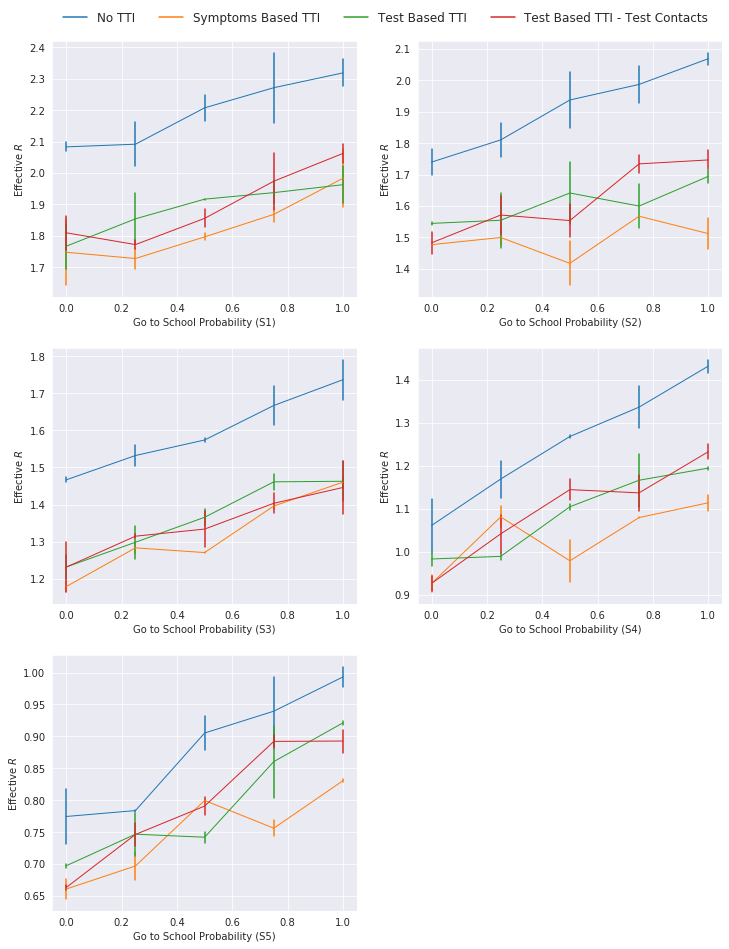

In [14]:
# Plot
fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

# Line plot
sns.lineplot(x="gts", y="effective_r", 
             data=df_result[df_result["strategy"] == "S1"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax1)
sns.lineplot(x="gts", y="effective_r", 
             data=df_result[df_result["strategy"] == "S2"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax2)
sns.lineplot(x="gts", y="effective_r", 
             data=df_result[df_result["strategy"] == "S3"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax3)
sns.lineplot(x="gts", y="effective_r", 
             data=df_result[df_result["strategy"] == "S4"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax4)
sns.lineplot(x="gts", y="effective_r", 
             data=df_result[df_result["strategy"] == "S5"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax5)

# Display one legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles[1:], labels=["No TTI", "Symptoms Based TTI", "Test Based TTI", "Test Based TTI - Test Contacts"], loc='center left', 
           bbox_to_anchor=(0, 1.09), ncol=4, frameon=False,
          prop={'size': 12})

# Remove legends
for ax in [ax2, ax3, ax4, ax5]:
    legend = ax.legend()
    legend.remove()

# Rename axis
ax1.set_xlabel("Go to School Probability (S1)")
ax1.set_ylabel("Effective $R$")


ax2.set_xlabel("Go to School Probability (S2)")
ax2.set_ylabel("Effective $R$")


ax3.set_xlabel("Go to School Probability (S3)")
ax3.set_ylabel("Effective $R$")


ax4.set_xlabel("Go to School Probability (S4)")
ax4.set_ylabel("Effective $R$")


ax5.set_xlabel("Go to School Probability (S5)")
ax5.set_ylabel("Effective $R$")

plt.show()

### Test/Trace Delay

This section experiments the effect of test/trace delay to effective R.

In [19]:
policy_name_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
test_params = [1, 2, 2, 3, 3]
trace_params = [1, 1, 2, 2, 3]
n_experiments = 2 # number of simulations performed for a particular value

In [22]:
# Used to store the experimentation result
dict_test_trace = {policy_name: {} for policy_name in policy_name_params}
for test_param, trace_param in zip(test_params, trace_params):
    for key in dict_test_trace.keys():
        dict_test_trace[key][(test_param, trace_param)] = []

In [23]:
# Try all possible policy and age parameters
for policy_name in tqdm(policy_name_params):
    
    for test_param, trace_param in zip(test_params, trace_params):
        # For each case, experiment n times
        for _ in range(n_experiments):
            outputs = do_simulation(policy_name, case_config, contacts_config, 
                                    n_cases=15000, dict_params={"testing_delay": test_param,
                                                               "manual_trace_delay": trace_param})
            dict_test_trace[policy_name][(test_param, trace_param)].append(outputs)

In [2]:
# Save experiment results
# filename = "experiments_result/experiment-app-tracing"
# save_data(filename, dict_mt)

# Load experiment results
# dict_compliance = load_data(filename)

In [24]:
key_params = [f"{i}_{j}" for i in ["S1", "S2", "S3", "S4", "S5"] for j in ["no_TTI", "symptom_based_TTI", "test_based_TTI", "test_based_TTI_test_contacts"]]
df_result = {"strategy": [], 
             "gov_policy": [],
             "test/trace": [],
             "effective_r": [], 
             "base_r": [],
             "manual_traces": [], 
             "app_traces": [], 
             "test_needed": [],
             "persondays_quarantined": []}
nppl = 120

for key in key_params:
    strategy = key[:2]
    gov_policy = key[3:]
    
    for test_param, trace_param in zip(test_params, trace_params):

        for i in range(n_experiments):
            result_format = pd.DataFrame(dict_test_trace[key][(test_param, trace_param)][i]).mean(0)
            df_result["test/trace"].append(f"{test_param}/{trace_param}")
            df_result["strategy"].append(strategy)
            df_result["gov_policy"].append(gov_policy)
            df_result["effective_r"].append(result_format.loc["Effective R"])
            df_result["base_r"].append(result_format.loc["Base R"])
            df_result["manual_traces"].append(result_format.loc["# Manual Traces"] * nppl)
            df_result["app_traces"].append(result_format.loc["# App Traces"] * nppl)
            df_result["test_needed"].append(result_format.loc["# Tests Needed"] * nppl)
            df_result["persondays_quarantined"].append(result_format.loc["# PersonDays Quarantined"])

In [25]:
# Convert to dataframe
df_result = pd.DataFrame(df_result)

In [ ]:
df_result.to_csv("experiments_result/test.csv", index=False)

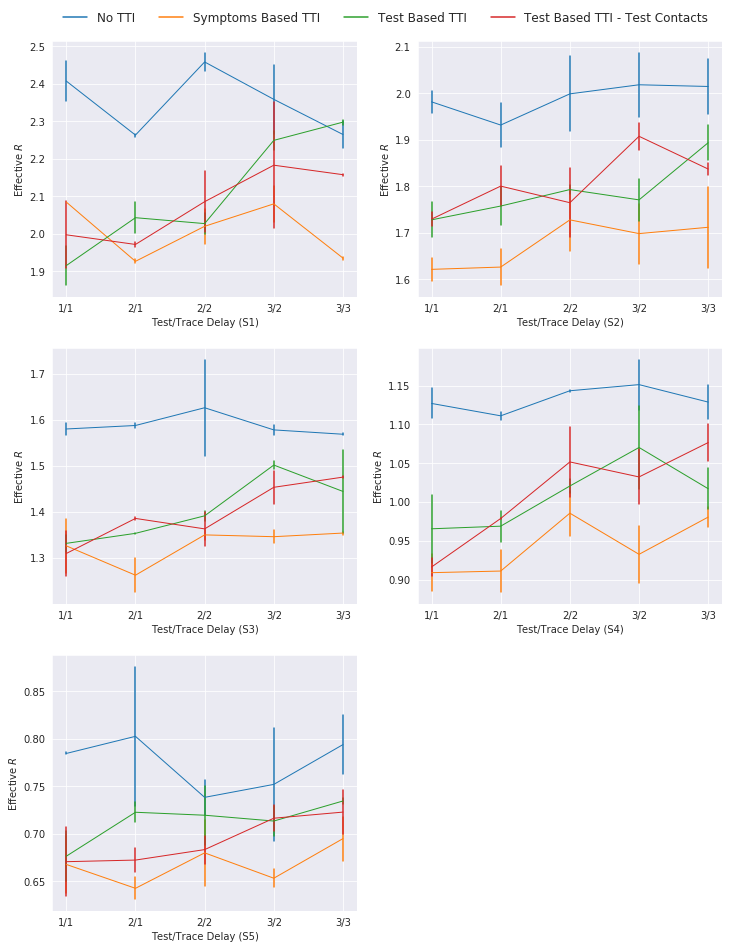

In [26]:
# Plot
fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

# Line plot
sns.lineplot(x="test/trace", y="effective_r", 
             data=df_result[df_result["strategy"] == "S1"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax1)
sns.lineplot(x="test/trace", y="effective_r", 
             data=df_result[df_result["strategy"] == "S2"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax2)
sns.lineplot(x="test/trace", y="effective_r", 
             data=df_result[df_result["strategy"] == "S3"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax3)
sns.lineplot(x="test/trace", y="effective_r", 
             data=df_result[df_result["strategy"] == "S4"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax4)
sns.lineplot(x="test/trace", y="effective_r", 
             data=df_result[df_result["strategy"] == "S5"], 
             hue="gov_policy", err_style="bars", linewidth=1,
             ci=95, ax=ax5)

# Display one legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles[1:], labels=["No TTI", "Symptoms Based TTI", "Test Based TTI", "Test Based TTI - Test Contacts"], loc='center left', 
           bbox_to_anchor=(0, 1.09), ncol=4, frameon=False,
          prop={'size': 12})

# Remove legends
for ax in [ax2, ax3, ax4, ax5]:
    legend = ax.legend()
    legend.remove()

# Rename axis
ax1.set_xlabel("Test/Trace Delay (S1)")
ax1.set_ylabel("Effective $R$")


ax2.set_xlabel("Test/Trace Delay (S2)")
ax2.set_ylabel("Effective $R$")


ax3.set_xlabel("Test/Trace Delay (S3)")
ax3.set_ylabel("Effective $R$")


ax4.set_xlabel("Test/Trace Delay (S4)")
ax4.set_ylabel("Effective $R$")


ax5.set_xlabel("Test/Trace Delay (S5)")
ax5.set_ylabel("Effective $R$")

plt.show()